<h1>About this Notebook</h1>

This notebook demonstrates the experience of using ML Workbench to create a machine learning model for text classification and setting it up for online prediction. This is the "cloud run" version of previous notebook. Preprocessing, training, batch prediction, are all done in cloud with various of services. The cloud run can be distributed, so it can handle really large data. Although in this case there is little benefit with the small demo data, the purpose is to demonstrate the usage of cloud run mode of ML Workbench.

There are only a few things that need to change between "local run" and "cloud run":

* all data sources or file paths must be on GCS.
* the --cloud flag must be set for each step.
* "cloud_config" can be set for cloud specific settings, such as project_id, machine_type. In some cases it is required.

Other than this, nothing else changes from local to cloud!
    
If you have any feedback, please send them to datalab-feedback@google.com.

# Validate Data

In [3]:
# Set up a new directory and make it working directory

!mkdir -p /content/datalab/workspace/text_classification_20newsgroup

import os
os.chdir('/content/datalab/workspace/text_classification_20newsgroup')

In [4]:
# Make sure you have the processed data there.
!ls ./data

eval.csv  train.csv  vocab.txt


# Create Model with ML Workbench

The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the cleaned data from the previous notebook and build a text classification model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

This notebook shows the cloud version of every command, and gives the normal experience when building models are large datasets. However, we will still use the 20 newsgroup data. 


## Setup: Move the data to GCS

The csv files, and all input files to the MLWorkbench magics must exist on GCS first. Therefore the first step is to make a new GCS bucket and copy the local csv files to GCS. 


In [13]:
!gsutil mb gs://datalab-mlworkbench-20newslab

Creating gs://datalab-mlworkbench-20newslab/...


In [16]:
!gsutil -m cp ./data/train.csv ./data/eval.csv gs://datalab-mlworkbench-20newslab

Copying file://./data/train.csv [Content-Type=text/csv]...
Copying file://./data/eval.csv [Content-Type=text/csv]...
- [2/2 files][ 11.7 MiB/ 11.7 MiB] 100% Done                                    
Operation completed over 2 objects/11.7 MiB.                                     


In [11]:
import google.datalab.contrib.mlworkbench.commands  # This loads the '%%ml' magics

## Step 1: Analyze

In cloud run, analysis is implemented with BigQuery. Running it may incur some costs.

In [15]:
%%ml analyze --cloud
output: gs://datalab-mlworkbench-20newslab/analysis
training_data:
    csv: gs://datalab-mlworkbench-20newslab/train.csv
    schema:
        - name: news_label
          type: STRING
        - name: text
          type: STRING
features:
    news_label:
        transform: target
    text:
        transform: bag_of_words

Analyzing column news_label...
column news_label analyzed.
Analyzing column text...
Updated property [core/project].
column text analyzed.
Updated property [core/project].


## Step 2: Transform

In cloud run, analysis is implemented with Cloud DataFlow. Running it may incur some costs.

In [17]:
%%ml transform --cloud
output: gs://datalab-mlworkbench-20newslab/transform
analysis: gs://datalab-mlworkbench-20newslab/analysis
prefix: features_train
training_data:
    csv: gs://datalab-mlworkbench-20newslab/train.csv
cloud_config:
    num_workers: 1

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
creating trainer.egg-info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
making hard links in trainer-1.0.0...
hard linking setup.py -> trainer-1.0.0
hard linking tr

In [18]:
%%ml transform --cloud
output: gs://datalab-mlworkbench-20newslab/transform
analysis: gs://datalab-mlworkbench-20newslab/analysis
prefix: features_eval
training_data:
    csv: gs://datalab-mlworkbench-20newslab/eval.csv
cloud_config:
    num_workers: 1

/usr/local/lib/python2.7/dist-packages/apache_beam/io/gcp/gcsio.py:113: DeprecationWarning: object() takes no parameters
  super(GcsIO, cls).__new__(cls, storage_client))
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
making hard links in trainer-1.0.0...
hard linking setup.py -> trainer-1.0.0
hard linking trainer/__init__.py -> trainer-1.0.0/trainer
hard linking trainer/feature_transfo

Click the links in output cell to monitor the jobs progress. Once they are completed (usually within 15 minutes with the job startup overhead), check the output.

In [22]:
!gsutil ls gs://datalab-mlworkbench-20newslab/transform

gs://datalab-mlworkbench-20newslab/transform/errors_features_eval-00000-of-00001.txt
gs://datalab-mlworkbench-20newslab/transform/errors_features_train-00000-of-00001.txt
gs://datalab-mlworkbench-20newslab/transform/features_eval-00000-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/features_eval-00001-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/features_eval-00002-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/features_train-00000-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/features_train-00001-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/features_train-00002-of-00003.tfrecord.gz
gs://datalab-mlworkbench-20newslab/transform/tmp/


## Step 3: Training

In cloud run, training is implemented with Cloud ML Engine Training service. Running it may incur some costs.

In [ ]:
# Training should use an empty output folder. So if you run training multiple times,
# use different folders or remove the output from the previous run.
!gsutil -m rm -fr gs://datalab-mlworkbench-20newslab/train

Note that, "runtime_version: '1.2'" specifies which TensorFlow version is used at training. The first time training is a bit slower because of warm up, but if you train it multiple times the runs after first will be faster.

In [24]:
%%ml train --cloud
output: gs://datalab-mlworkbench-20newslab/train
analysis: gs://datalab-mlworkbench-20newslab/analysis
training_data:
    transformed: gs://datalab-mlworkbench-20newslab/transform/features_train-*
evaluation_data:
    transformed: gs://datalab-mlworkbench-20newslab/transform/features_eval-*
model_args:
    model: linear_classification
    top-n: 3
    max-steps: 10000
    save-checkpoints-secs: 60
    train-batch-size: 500
cloud_config:
    scale_tier: STANDARD_1
    region: us-central1
    runtime_version: '1.2'

Job "trainer_task_170815_212703" submitted. Click here to view cloud log.

In [26]:
# Once training is done, check the output.
!gsutil list gs://datalab-mlworkbench-20newslab/train

gs://datalab-mlworkbench-20newslab/train/schema_without_target.json
gs://datalab-mlworkbench-20newslab/train/evaluation_model/
gs://datalab-mlworkbench-20newslab/train/model/
gs://datalab-mlworkbench-20newslab/train/staging/
gs://datalab-mlworkbench-20newslab/train/train/


In [27]:
# You can start Tensorboard by using Datalab's ML library.
# Note that the events will show up a few minutes after you start TensorBoard because it takes time to load events from GCS.
# Sometimes refreshing the page helps too.

from google.datalab.ml import TensorBoard

tid = TensorBoard.start('gs://datalab-mlworkbench-20newslab/train')

TensorBoard was started successfully with pid 132192. Click here to access it.

In [28]:
# You can also plot the summary events which will be saved with the notebook.

from google.datalab.ml import Summary

summary = Summary('gs://datalab-mlworkbench-20newslab/train')
summary.list_events()

{u'accuracy': {'gs://datalab-mlworkbench-20newslab/train/train/eval'},
 u'global_step/sec': {'gs://datalab-mlworkbench-20newslab/train/train'},
 u'input_producer/fraction_of_32_full': {'gs://datalab-mlworkbench-20newslab/train/train'},
 u'loss': {'gs://datalab-mlworkbench-20newslab/train/train',
  'gs://datalab-mlworkbench-20newslab/train/train/eval'},
 u'shuffle_batch/fraction_over_10_of_5500_full': {'gs://datalab-mlworkbench-20newslab/train/train'}}

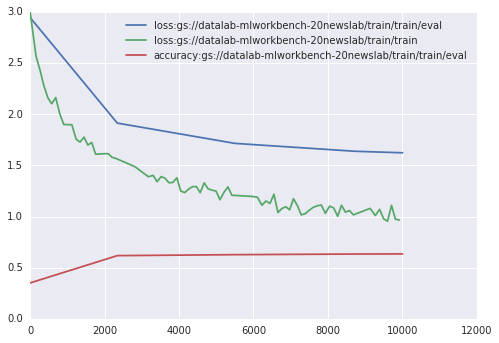

In [29]:
summary.plot(['loss', 'accuracy'])

## Step 4: Evaluation using batch prediction

See previous notebook (Text Classification --- 20NewsGroup (small data)). You can do local batch prediction with the model trained in cloud.

In [31]:
%%ml batch_predict
model: gs://datalab-mlworkbench-20newslab/train/evaluation_model
output: ./batch_predict_cloud_model
format: csv
prediction_data:
    csv: ./data/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from gs://datalab-mlworkbench-20newslab/train/evaluation_model/variables/variables
done.


In [32]:
!head -n 5 ./batch_predict_cloud_model/predict_results_eval.csv

rec.autos,comp.sys.mac.hardware,rec.sport.baseball,0.252283,0.181238,0.0824743,rec.autos
comp.windows.x,comp.graphics,rec.motorcycles,0.387877,0.356362,0.0309316,comp.windows.x
rec.motorcycles,rec.sport.baseball,comp.os.ms-windows.misc,0.0719544,0.0671989,0.059378,alt.atheism
talk.politics.guns,talk.politics.mideast,talk.politics.misc,0.40723,0.28827,0.172166,talk.politics.mideast
alt.atheism,rec.autos,sci.space,0.129724,0.0720822,0.0661296,talk.religion.misc


# Prediction

## Local Instant Prediction

Local instant prediction works with model trained in cloud too.

In [33]:
%%ml predict
model: gs://datalab-mlworkbench-20newslab/train/model
headers: text
prediction_data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,probability,probability_2,probability_3,text
sci.space,rec.motorcycles,rec.sport.baseball,0.102222,0.064993,0.063197,nasa
comp.os.ms-windows.misc,comp.graphics,misc.forsale,0.143492,0.063391,0.060048,windows xp


## Deploying Model to ML Engine

In [34]:
from google.datalab.ml import Models, ModelVersions

# Makes a ML Engine Model
try:
    Models().create('news')  
except:
    # If model exists.
    pass

# Makes a ML Engine Version
ModelVersions('news').deploy(
    version_name='v3',
    path='gs://datalab-mlworkbench-20newslab/train/model')

Waiting for operation "projects/datalab-demo-project/operations/create_news_v3-1502834001931"
Done.


## Online Prediction

In [35]:
%%ml predict --cloud
model: news.v3
headers: text
prediction_data:
  - nasa
  - windows xp

predicted,predicted_2,predicted_3,probability,probability_2,probability_3,text
sci.space,rec.motorcycles,rec.sport.baseball,0.102222,0.064993,0.063197,nasa
comp.os.ms-windows.misc,comp.graphics,misc.forsale,0.143492,0.063391,0.060048,windows xp


## Online Batch Prediction

In [40]:
# Let's create a CSV file from eval.csv by removing the target column.
with open('./data/eval.csv', 'r') as f, open('./data/test.csv', 'w') as fout:
    for l in f:
        fout.write(l.split(',')[1])

In [41]:
!gsutil -m cp ./data/test.csv gs://datalab-mlworkbench-20newslab

Copying file://./data/test.csv [Content-Type=text/csv]...
- [1/1 files][  4.2 MiB/  4.2 MiB] 100% Done                                    
Operation completed over 1 objects/4.2 MiB.                                      


In [44]:
%%ml batch_predict --cloud
model: news.v3
output: gs://datalab-mlworkbench-20newslab/prediction
format: json
prediction_data:
    csv: gs://datalab-mlworkbench-20newslab/test.csv
cloud_config:
    region: us-central1

Job "prediction_170815_220602" submitted. Click here to view cloud log.

Once job is completed, take a look at the results.

In [47]:
!gsutil ls -lh gs://datalab-mlworkbench-20newslab/prediction

      40 B  2017-08-15T22:10:46Z  gs://datalab-mlworkbench-20newslab/prediction/prediction.errors_stats-00000-of-00001
  80.3 KiB  2017-08-15T22:10:39Z  gs://datalab-mlworkbench-20newslab/prediction/prediction.results-00000-of-00002
144.35 KiB  2017-08-15T22:10:39Z  gs://datalab-mlworkbench-20newslab/prediction/prediction.results-00001-of-00002
TOTAL: 3 objects, 230079 bytes (224.69 KiB)


In [49]:
!gsutil cat gs://datalab-mlworkbench-20newslab/prediction/prediction.results* | head -n 2

{"probability": 0.9639276266098022, "predicted": "sci.med", "probability_3": 0.0044321282766759396, "probability_2": 0.014010959304869175, "predicted_2": "rec.motorcycles", "predicted_3": "alt.atheism"}
{"probability": 0.07142668217420578, "predicted": "rec.autos", "probability_3": 0.0668724849820137, "probability_2": 0.06724458932876587, "predicted_2": "rec.sport.hockey", "predicted_3": "rec.motorcycles"}


## BigQuery to analyze prediction results

Sometimes you want to query your prediction/evaluation results using SQL. It is easy.

In [54]:
# Use Datalab's Bigquery API to load CSV files into table.

import google.datalab.bigquery as bq
import json

with open('./batch_predict_cloud_model/predict_results_schema.json', 'r') as f:
  schema = json.load(f)

# Remove the target column because the schema file we use is from previous evaluation results.
del schema[-1] 

# Create BQ Dataset
bq.Dataset('newspredict').create()

# Create the table
table = bq.Table('newspredict.result2').create(schema=schema, overwrite=True)
table.load('gs://datalab-mlworkbench-20newslab/prediction/prediction.results*', mode='overwrite', source_format='json')

Job datalab-demo-project/job_eAxiMAjTyERs2Sofwaeg6j8ChPSn completed

Now, run any SQL queries on "table newspredict.result1". Below we query some "weak" results.

In [61]:
%%bq query
SELECT * FROM newspredict.result2 WHERE probability < 0.1

predicted,predicted_2,predicted_3,probability,probability_2,probability_3
sci.space,rec.motorcycles,sci.med,0.0898567810655,0.0825914293528,0.0789966359735
rec.motorcycles,comp.sys.mac.hardware,sci.med,0.076315484941,0.0738198906183,0.0652579665184
rec.motorcycles,comp.os.ms-windows.misc,sci.med,0.0862247943878,0.0846209824085,0.0651038885117
sci.electronics,comp.sys.mac.hardware,sci.med,0.0745724365115,0.0687986686826,0.0668958127499
soc.religion.christian,alt.atheism,sci.med,0.0740862712264,0.0721479579806,0.0705471336842
sci.med,rec.motorcycles,rec.autos,0.0945234596729,0.0697456151247,0.0615919604897
sci.space,rec.motorcycles,rec.autos,0.0877444073558,0.0838762894273,0.0787376984954
sci.space,talk.politics.mideast,rec.autos,0.0766582489014,0.0721520259976,0.0680164322257
alt.atheism,rec.sport.baseball,rec.autos,0.0831458196044,0.0690513774753,0.0658900812268
rec.motorcycles,rec.sport.baseball,rec.autos,0.0697844997048,0.0675952807069,0.0626377090812


## Prediction from a python client

See the previous notebook in this sequence for the example. 

# Clean up

This section is optional. We will delete all the GCP resources and local files created in this sequence of notebooks. If you are not ready to delete anything, don't run any of the following cells.


In [50]:
# Delete the version

ModelVersions('news').delete('v3')

Waiting for operation "projects/datalab-demo-project/operations/delete_news_v3-1502835640920"
Done.


In [62]:
# Delete the model
Models().delete('news')

Waiting for operation "projects/datalab-demo-project/operations/delete_model_news-1502836201"
Done.


In [ ]:
# Delete the files in the GCS bucket, and delete the bucket
!gsutil -m rm -r gs://datalab-mlworkbench-20newslab

In [66]:
# Delete BQ table

bq.Dataset('newspredict').delete(delete_contents = True)